# An Example of an Ad-hoc Analysis with climate articles by Topic Modeling 

This is an example of how to perform an ad-hoc analysis with topic modeling.

In this example, articles from Dagens Nyheter's (DN) tagged with climate "Klimatet" are chosen, and then a topic modeling algorithm is applied to this data to learn what concepts (topics) DN is writing about in the context of the climate.

There are several settings that can be tuned for choosing which articles to be loaded from BigQuery, as well as hyperparameters for the algorithms. There are two different topic modeling algorithms implemented in this example, non-negative matrix factorization (NMF) and Latent Dirichlet Allocation (LDA).

In [4]:
# Necessary for importing modules from a sub-directory
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
if os.getcwd().split('/')[-1] == 'notebook_examples':
    os.chdir(r"../")


# Importing libraries
import pandas_gbq
import pickle
import numpy as np
import pandas as pd
import gensim
import matplotlib.pyplot as plt

from sklearn.decomposition import NMF
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim import matutils, models, corpora
from src.efselabwrapper.pipeline import run_processing_pipeline

## Data Settings
This is where the parameters are set for choosing which articles to perform topic modeling with.

In this example, 500 articles from Dagens Nyheter with the tag "Klimatet" from the year 2020 are chosen.

The number of articles needs to big enough to make the statistical relationships between the words reliable, hence giving meaningful topics. For advanced analysis we recommend this to be bigger than 5000, preferably around 10 000. To preprocess 10 000 articles takes about 1.5-2 minutes (which is the most time-consuming part of the modeling).

In [5]:
#Reading dataset from BigQuery

# TODO, READ DATA

Downloading: 100%|██████████| 500/500 [00:01<00:00, 364.42rows/s]


In [6]:
# Quick test to see if the dataframe hold the data we want
df.head()

,brand,tag_name,content_text,publication_time
0,DAGENS_NYHETER,Klimatet,Vegoburgaren överlevde omröstning i EU-parlame...,2020-10-23 11:12:54.330000+00:00
1,DAGENS_NYHETER,Klimatet,Sparkad gruvarbetare utmanar i Trumps fäste Wy...,2020-11-01 20:47:11.407000+00:00
2,DAGENS_NYHETER,Klimatet,”Sverige behöver en ny kärnkraftslagstiftning”...,2020-07-26 19:00:00+00:00
3,DAGENS_NYHETER,Klimatet,”Reduktionsplikten räcker inte för att nå klim...,2020-06-29 13:05:28+00:00
4,DAGENS_NYHETER,Klimatet,Nya Zeeland ska förklara klimatnödläge – Arder...,2020-11-27 08:11:15.495000+00:00


## Model Settings
This is where parameters for the modeling are chosen.
Part of Speech Tags (pos_tags) represents which Part of Speach classes are used in the modeling. In this example, all classes except nouns are filtered out.

The number of topics can be chosen as well as which algorithm to use. Which algorithm to use is highly use case dependent, hence there is no general best algorithm. A throughout comparison between the two algorithms can be found in our thesis (link in README), but as a short summary one can say that NMF is faster and creates more specific topics while LDA is slower and create more general and comprehensive topics.

In [7]:
# tags to choose:
# ['PROPN', 'NOUN', 'ADJ', 'VERB', 'ADV', 'SCONJ', 'AUX', 'PUNCT', 'ADP', 'PRON','DET', 'PART', 'CCONJ', 'NUM', 'INTJ']
pos_tags = ["NOUN"]

# Choose algorithm, LDA or NMF
algorithm = 'NMF' #'NMF' | 'LDA'

# Number of topics
NUM_TOPICS = 20

# NMF settings
NMF_NORM = 'frobenius' # ‘frobenius’ | ‘kullback-leibler’ | ‘itakura-saito’
NMF_SOLVER = 'mu' # ‘cd’ | ‘mu’
INIT = None # None | ‘random’ | ‘nndsvd’ | ‘nndsvda’ | ‘nndsvdar’ | ‘custom’
ALPHA = 0 # float

In [8]:
# Preprocess
efselab_parsed_corpus = run_processing_pipeline(df, pos_tags)

## Build Topic Model

In [9]:
if algorithm == 'LDA':
    # Set mallet path
    mallet_path ='src/mallet-2.0.8/bin/mallet'
    
    # Format Gensim components for data
    id2word = corpora.Dictionary(efselab_parsed_corpus)
    id2word.filter_extremes(no_below=2)
    corpus = [id2word.doc2bow(text) for text in efselab_parsed_corpus]

    # Train model
    model = models.wrappers.LdaMallet(mallet_path,
                                      corpus=corpus,
                                      id2word=id2word,
                                      num_topics=NUM_TOPICS)
    topics = model.show_topics(num_topics=NUM_TOPICS, num_words=10, formatted=False)
    
    doc_topic_weights = np.array([[e[1] for e in doc] for doc in model[corpus]])

    
if algorithm == 'NMF':
    # Create TF-IDF
    vectorizer = TfidfVectorizer(
        lowercase=False,
        tokenizer=lambda x: x,
        max_df=0.95,
        min_df=2,
        max_features=None,
        use_idf=True
    )
    tf_idf = vectorizer.fit_transform(efselab_parsed_corpus)
    feature_names = vectorizer.get_feature_names()
    
    # Train model
    model = NMF(random_state=0, tol=0.0001, verbose=0, shuffle=False,\
            n_components=NUM_TOPICS, beta_loss=NMF_NORM, solver=NMF_SOLVER, \
            init=INIT, alpha=ALPHA, max_iter=500)

    W = model.fit_transform(tf_idf, y=feature_names)
    H = model.components_   

    def get_NMF_topics(model, feature_names, n_top_words):
        all_topics = []
        for topic_idx, topic in enumerate(model.components_):
            sumtopic = np.sum(topic)
            topic_formatted = (topic_idx, [(feature_names[i], topic[i]/sumtopic) for i in topic.argsort()[:-n_top_words - 1:-1]])
            all_topics.append(topic_formatted)
        return all_topics

    topics = get_NMF_topics(model, feature_names, 10)
    doc_topic_weights = W

doc_topic = [np.argmax(e) for e in doc_topic_weights]
topic_counts = [doc_topic.count(i) for i in range(len(topics))]


## Print Topics

T1: värld kris bok klimat samhälle jord klimatkris klimatförändring liv framtid 
T2: grad temperatur vinter medeltemperatur värmebölja klimatförändring sommar genomsnitt värme värmerekord 
T3: utbyggnad regering raffinaderi domstol miljööverdomstol anläggning oljeraffinaderi miljöparti ansökan mark 
T4: utsläpp koldioxid atmosfär ton växthusgas koldioxidhalt grad bränsle minskning uppvärmning 
T5: land parisavtal klimatarbete värld avtal mål president klimatplan utsläppsland klimatmöte 
T6: brand skogsbrand koala delstat eld regnskog augusti brandsäsong hus hem 
T7: art djur mångfald växt forskare natur jordbruk träd vatten rapport 
T8: investering ekonomi regering omställning coronakris företag råd stöd bransch politik 
T9: mat kött produkt livsmedel matsvinn klimat svensk klimatpåverkan konsument ost 
T10: kommun översvämning meter vall skyddsvall vatten hav havsnivå klimatförändring område 
T11: bil trafikverk elbil fordon biodrivmedel trafik elektrifiering biltrafik regering rappor

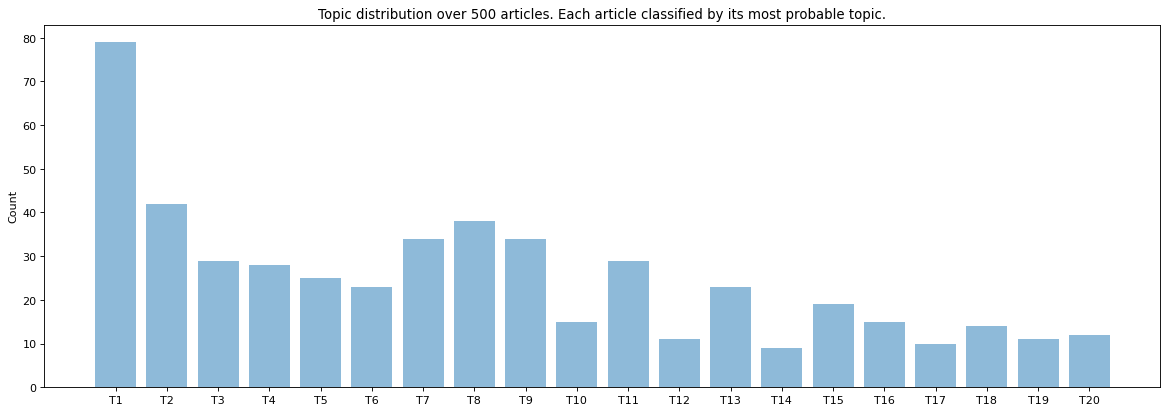

In [10]:
for topic in topics:
    print(f'T{topic[0]+1}:', ' '.join([f'{e[0]}' for e in topic[1]]), '')
    
# Plot bar chart
plt.figure(num=None, figsize=(18, 6), dpi=80, facecolor='w', edgecolor='k')
topic_axis = [f'T{i+1}' for i in range(len(topics))]
y_pos = np.arange(len(topic_axis))
plt.bar(y_pos, topic_counts, align='center', alpha=0.5)
plt.xticks(y_pos, topic_axis)
plt.ylabel('Count')
plt.title(f'Topic distribution over {sum(topic_counts)} articles. Each article classified by its most probable topic.')
plt.show()

In [11]:
import pyLDAvis
pyLDAvis.enable_notebook()

if algorithm == 'LDA':
    import pyLDAvis.gensim
    conv_model = gensim.models.wrappers.ldamallet.malletmodel2ldamodel(model)
    
if algorithm == 'NMF':
    W_norm = W / W.sum(axis=1)[:, None]
    H_smooth = np.add(H, 0.000000000001)
    H_norm = H_smooth / H_smooth.sum(axis=1)[:, None]
    term_freq = tf_idf.sum(axis=0).getA1()
    doc_len = tf_idf.sum(axis=1).getA1()

    opts = {'vocab': feature_names, 
            'doc_lengths': doc_len.tolist(),
            'term_frequency': term_freq.tolist(),
            'doc_topic_dists': W_norm.tolist(),
            'topic_term_dists': H_norm.tolist(),
            'sort_topics': False
           }
    
pyLDAvis.gensim.prepare(conv_model, corpus, id2word, sort_topics=False) if algorithm == 'LDA' else pyLDAvis.prepare(**opts)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.050239  0.034563       1        1  17.274238
1      0.236679 -0.069500       2        1   7.086920
2     -0.092311  0.008228       3        1   5.109620
3     -0.084961 -0.132566       4        1   5.774333
4     -0.036126 -0.195165       5        1   4.810174
5      0.232990  0.033187       6        1   3.690770
6      0.174188  0.162638       7        1   6.604932
7     -0.173234  0.033131       8        1   6.518776
8     -0.039684  0.252232       9        1   6.444302
9      0.145576 -0.054461      10        1   4.132913
10    -0.157504 -0.053608      11        1   4.895831
11    -0.050727  0.113307      12        1   3.090754
12    -0.037123 -0.003408      13        1   4.154791
13    -0.041174 -0.102121      14        1   2.082762
14    -0.133562 -0.013362      15        1   4.205351
15     0.023616  0.005087      16        1   3.098586
16    -0.187152 -0.047926      17        1   2.383233
17    -0.087449 -0.069168      18        1   3.515767
18     0.260697 -0.147459      19        1   2.192873
19    -0.002977  0.246367      20        1   2.933075, topic_info=         Term       Freq      Total Category  logprob  loglift
2850     möte  11.000000  11.000000  Default  30.0000  30.0000
405     brand  12.000000  12.000000  Default  29.0000  29.0000
4527  utsläpp  19.000000  19.000000  Default  28.0000  28.0000
2028      kol   9.000000   9.000000  Default  27.0000  27.0000
3074    orkan   7.000000   7.000000  Default  26.0000  26.0000
...       ...        ...        ...      ...      ...      ...
2175     krav   0.786097   4.766683  Topic20  -4.8778   1.7268
1429     hand   0.566175   2.780894  Topic20  -5.2060   1.9375
4591   vatten   0.632793   6.212773  Topic20  -5.0948   1.2449
412   bransch   0.559159   4.236965  Topic20  -5.2185   1.5039
2637    miljö   0.548676   5.393353  Topic20  -5.2374   1.2437

[1253 rows x 6 columns], token_table=      Topic      Freq          Term
term                               
26        1  0.505123      aktivist
26       16  0.505123      aktivist
35       19  0.867018       alfabet
41        1  0.368332        allvar
41        5  0.368332        allvar
...     ...       ...           ...
4881     11  0.178980        åtgärd
4893      4  0.349156        ökning
4893     15  0.349156        ökning
4923     10  0.688516  översvämning
4923     19  0.344258  översvämning

[999 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20])